In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as s

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def load_data(train_batch_size, test_batch_size):
    """
    Load the MNIST dataset with training and test sets.

    Parameters:
    - train_batch_size: Batch size for the training dataset.
    - test_batch_size: Batch size for the test dataset.

    Returns:
    - Tuple of DataLoader for the training and test sets.
    """
    # Normalize the dataset
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to 32x32
        transforms.ToTensor(),  # Convert images to tensor format
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize images
    ])

    # Fetch training data: total 60000 samples
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True, num_workers=8)

    # Fetch test data: total 10000 samples
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transform),
        batch_size=test_batch_size, shuffle=True, num_workers=8)

    return train_loader, test_loader


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.adap_pool2d = nn.AdaptiveAvgPool2d((5, 5))  # Adaptive pooling to ensure output size is 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with a 50% drop probability

        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize weights and biases
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.adap_pool2d(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x


In [5]:
def define_optimizer(model):
    return optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

In [6]:
def train(model, optimizer, train_loader):
    model.train()

    # Loop over each batch from the training data.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        optimizer.step()


In [7]:
def calculate_loss(model, loader, loss_fn):
    # Initialize
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0


    with torch.no_grad():
        for batch in loader:
            data, target = batch

            # Forward pass
            output = model(data)

            cost = loss_fn(output, target)
            costTotal += cost.item()
            costCounter += 1

            # Compute the number of correct predictions
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1

    return costTotal / costCounter, round(correct / total, 3)


In [8]:
def compute(model, optimizer):
    # Initialize lists to store loss and accuracy metrics for both train and test sets
    loss_train_arr = []
    loss_test_arr = []
    test_acc_arr = []
    train_acc_arr = []

    # Loop over each epoch to train and evaluate the model
    for epoch in range(1, epochs + 1):
        train(model, optimizer, train_loader)  # Train the model using the training data
        tr_loss, tr_acc = calculate_loss(model, train_loader, loss_fn)  # Evaluate training loss and accuracy
        t_loss, t_acc = calculate_loss(model, test_loader, loss_fn)  # Evaluate testing loss and accuracy
        print("Model Train loss: ", tr_loss)  # Print training loss for the current epoch
        # Append the metrics to their respective lists for later analysis
        loss_train_arr.append(tr_loss)
        loss_test_arr.append(t_loss)
        train_acc_arr.append(tr_acc)
        test_acc_arr.append(t_acc)

    # Return the collected metrics for all epochs
    return loss_train_arr, loss_test_arr, train_acc_arr, test_acc_arr


In [9]:
epochs = 30

**UPDATED LR = 1e-3**

In [10]:
torch.manual_seed(1)
loss_fn = torch.nn.CrossEntropyLoss()
train_loader, test_loader = load_data(500, 500)
model2 = CNN()
optimizer = define_optimizer(model2)
batch_2_train_loss, batch_2_test_loss, batch_2_train_acc, batch_2_test_acc = compute(model2, optimizer)

batch_param_2 = torch.nn.utils.parameters_to_vector(model2.parameters())

torch.manual_seed(1)
loss_fn = torch.nn.CrossEntropyLoss()
train_loader, test_loader = load_data(100, 100)
model1 = CNN()
optimizer = define_optimizer(model1)
batch_1_train_loss, batch_1_test_loss, batch_1_train_acc, batch_1_test_acc = compute(model1, optimizer)

batch_param_1 = torch.nn.utils.parameters_to_vector(model1.parameters())

100%|██████████| 9912422/9912422 [00:00<00:00, 104930610.05it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23152846.68it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31223408.88it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23091550.02it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model Train loss:  2.3008113066355387
Model Train loss:  2.298725531498591
Model Train loss:  1.9951237936814625
Model Train loss:  0.63723523914814
Model Train loss:  0.37746826857328414
Model Train loss:  0.26769258504112564
Model Train loss:  0.2034375134855509
Model Train loss:  0.1741626737639308
Model Train loss:  0.15324891408284505
Model Train loss:  0.1360223351046443
Model Train loss:  0.12814036924391986
Model Train loss:  0.1171918132652839
Model Train loss:  0.11071520851304134
Model Train loss:  0.10104606387515863
Model Train loss:  0.09864782588556409
Model Train loss:  0.09001432635510961
Model Train loss:  0.08502108029400308
Model Train loss:  0.07760218014009297
Model Train loss:  0.08185280710458756
Model Train loss:  0.0806400295967857
Model Train loss:  0.07546599026148518
Model Train loss:  0.06969890566542744
Model Train loss:  0.06840521140644948
Model Train loss:  0.06783230418028931
Model Train loss:  0.06704137831305464
Model Train loss:  0.060463471741726


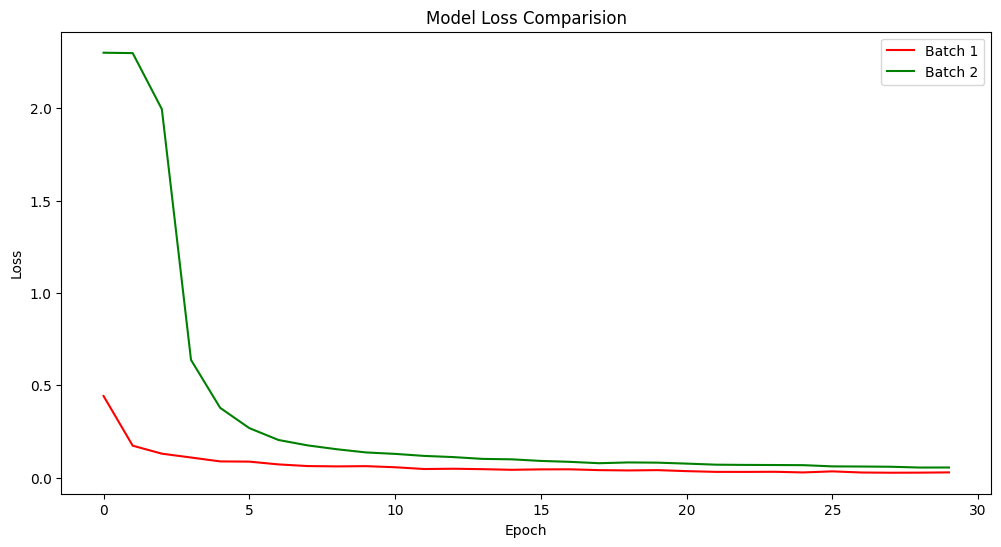

In [11]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 30, 1), batch_1_train_loss, color = "r")
plt.plot(np.arange(0, 30, 1), batch_2_train_loss, color = "g")
plt.title('Model Loss Comparision')
plt.legend(['Batch 1', 'Batch 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

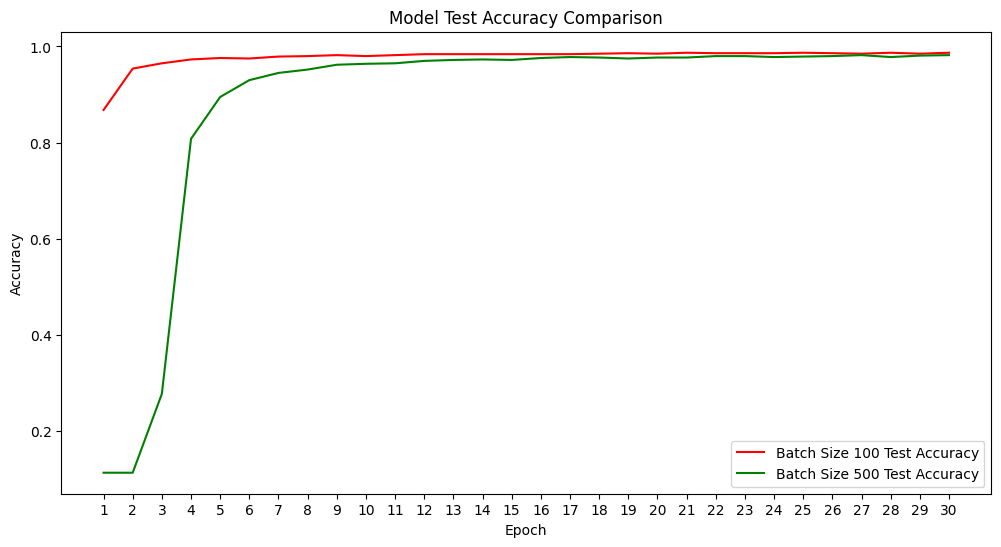

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(batch_1_test_acc) + 1), batch_1_test_acc, color="r")
plt.plot(np.arange(1, len(batch_2_test_acc) + 1), batch_2_test_acc, color="g")
plt.title('Model Test Accuracy Comparison')
plt.legend(['Batch Size 100 Test Accuracy', 'Batch Size 500 Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, len(batch_1_test_acc) + 1, step=1))
plt.show()

In [13]:
alpha = np.linspace(-2.0, 2.0, num = 50)
thetaArr =[]
for i in range (len(alpha)):
    theta = (1-alpha[i])*batch_param_1 + alpha[i]* batch_param_2
    thetaArr.append(theta)

In [14]:
alpha_train_loss_arr = []
alpha_test_loss_arr = []
alpha_train_acc_arr = []
alpha_test_acc_arr = []

In [15]:
for i in range (len(thetaArr)):
    torch.manual_seed(1)
    theta = (1-alpha[i])* batch_param_1 + alpha[i]*batch_param_2
    model = CNN()
    torch.nn.utils.vector_to_parameters(theta, model.parameters())
    loss_func = nn.CrossEntropyLoss()

    temp = []
    for param in model.parameters():
        temp.append(torch.numel(param))

    alpha_train_loss, alpha_train_acc = calculate_loss(model, train_loader, loss_fn)
    alpha_test_loss, alpha_test_acc = calculate_loss(model, test_loader, loss_fn)
    alpha_train_loss_arr.append(alpha_train_loss)
    alpha_train_acc_arr.append(alpha_train_acc)
    alpha_test_loss_arr.append(alpha_test_loss)
    alpha_test_acc_arr.append(alpha_test_acc)

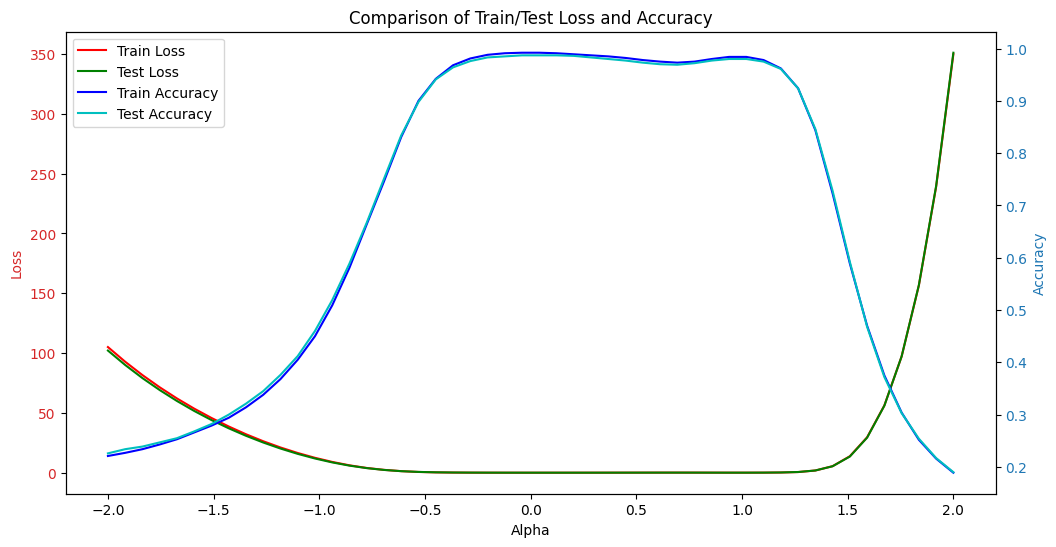

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color=color)
l1, = ax1.plot(alpha, alpha_train_loss_arr, color="r", label='Train Loss')
l2, = ax1.plot(alpha, alpha_test_loss_arr, color="g", label='Test Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
l3, = ax2.plot(alpha, alpha_train_acc_arr, color="b", label='Train Accuracy')
l4, = ax2.plot(alpha, alpha_test_acc_arr, color="c", label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

legends = [l1, l2, l3, l4]
labels = [l.get_label() for l in legends]
ax1.legend(legends, labels, loc='upper left')

plt.title('Comparison of Train/Test Loss and Accuracy')
plt.show()


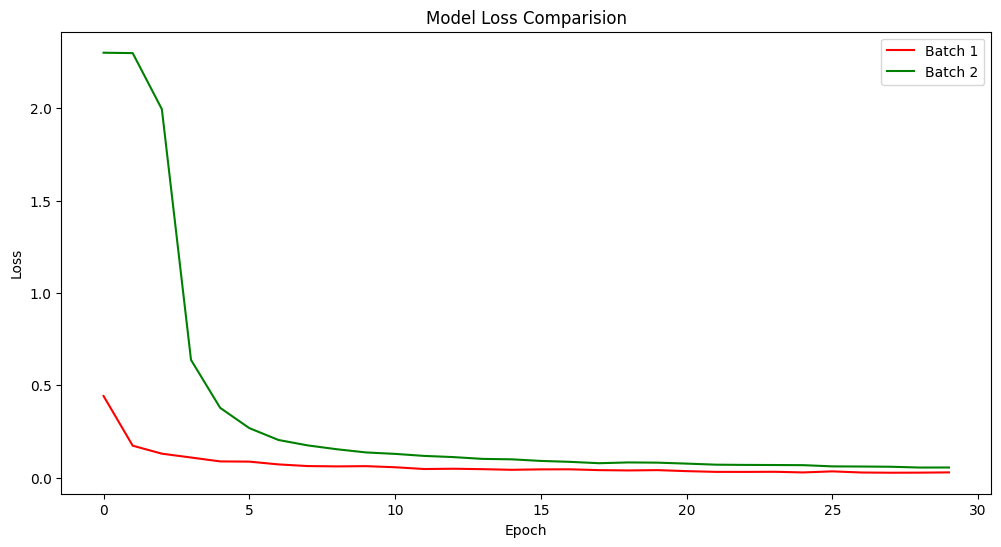

In [17]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 30, 1), batch_1_train_loss, color = "r")
plt.plot(np.arange(0, 30, 1), batch_2_train_loss, color = "g")
plt.title('Model Loss Comparision')
plt.legend(['Batch 1', 'Batch 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

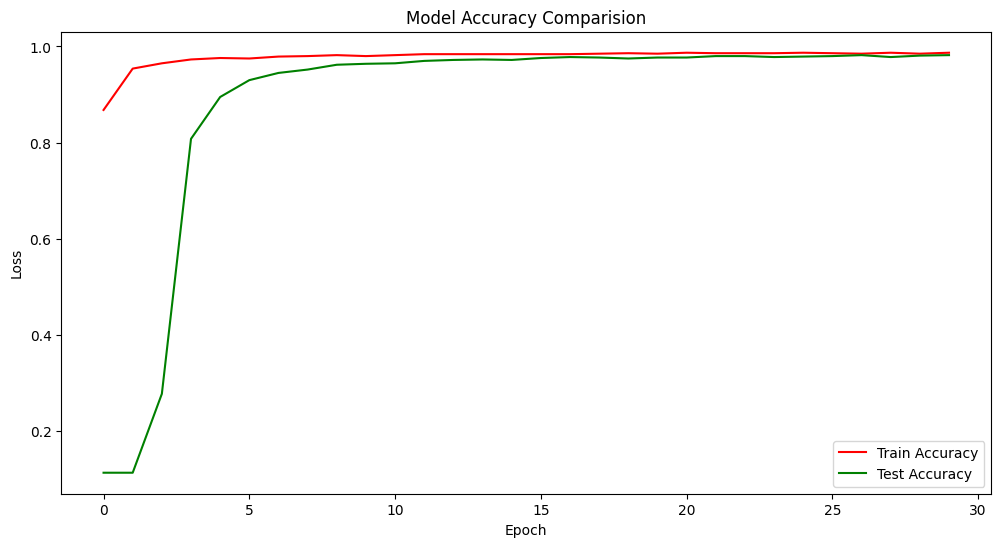

In [18]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 30, 1), batch_1_test_acc, color = "r")
plt.plot(np.arange(0, 30, 1), batch_2_test_acc, color = "g")
plt.title('Model Accuracy Comparision')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
alpha_train_loss_arr = []
alpha_test_loss_arr = []
alpha_train_acc_arr = []
alpha_test_acc_arr = []

In [20]:
for i in range (len(thetaArr)):
    torch.manual_seed(1)
    theta = (1-alpha[i])* batch_param_1 + alpha[i]*batch_param_2
    model = CNN()
    torch.nn.utils.vector_to_parameters(theta, model.parameters())
    loss_func = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay = 1e-4)

    temp = []
    for param in model.parameters():
        temp.append(torch.numel(param))

    alpha_train_loss, alpha_train_acc = calculate_loss(model, train_loader, loss_fn)
    alpha_test_loss, alpha_test_acc = calculate_loss(model, test_loader, loss_fn)
    alpha_train_loss_arr.append(alpha_train_loss)
    alpha_train_acc_arr.append(alpha_train_acc)
    alpha_test_loss_arr.append(alpha_test_loss)
    alpha_test_acc_arr.append(alpha_test_acc)

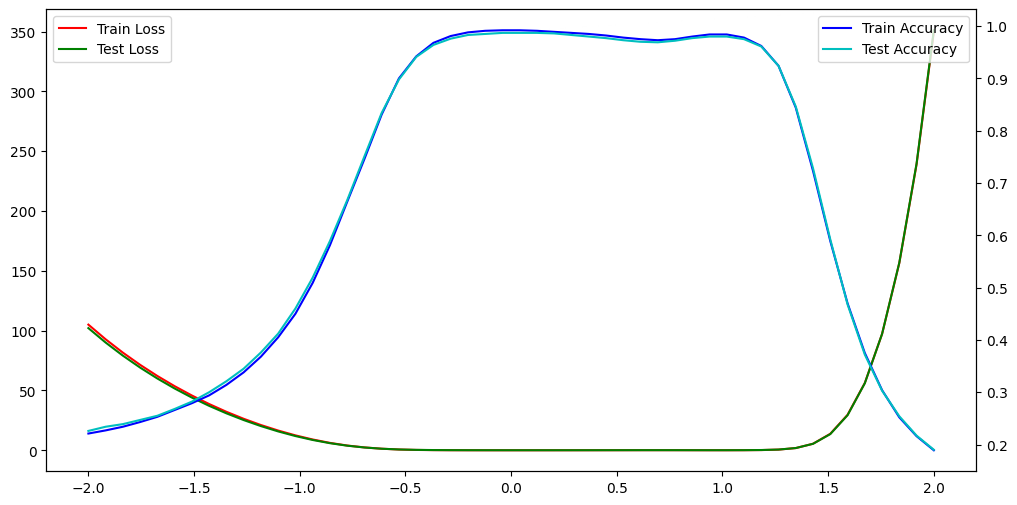

In [21]:
plt.figure(figsize=(12,6))
plt.plot(alpha, alpha_train_loss_arr, color = "r")
plt.plot(alpha, alpha_test_loss_arr, color = "g")
plt.legend(['Train Loss' , 'Test Loss'])

plt.twinx()

plt.plot(alpha, alpha_train_acc_arr, color = "b")
plt.plot(alpha, alpha_test_acc_arr, color = "c")
plt.legend(['Train Accuracy' , 'Test Accuracy'])